# Image Object Detection with YOLOV3 (OpenCV library) 

## Importing Libraries

First step, we need to import OpenCV, Numpy and Matplotlib libraries.

In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

## Loading Model Configuration and Pre-trained Weights

Let's load Yolov3 model configuration and pre-trained weights by reading "yolov3.cfg" and yolov3.weights".
We also need to extract class names from the file "coco.names".

In [6]:
## Loading network configuration and pre-trained weights 
net = cv2.dnn.readNet("yolov3.weights", "/home/pasquale/OBJ_DETECTION/darknet/cfg/yolov3.cfg") 

## Save all the class names in a list  (80 CLASSES)
with open("/home/pasquale/OBJ_DETECTION/darknet/data/coco.names", "r") as f:     
    classes = [word.strip() for word in f.readlines()] 
    
## Get layer names of the network 
layer_names = net.getLayerNames() 

## Determine the output layer names from the YOLO model  
# (net.getUnconnectedOutLayers() gives the index position of the layers)
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()] 

print("YOLOv3 LOADED SUCCESSFULLY")

YOLOv3 LOADED SUCCESSFULLY


This is all we need in order to load the model configuration and pre-trained weights.
The next step is to load the image.

## Loading Image

We load and show the image.

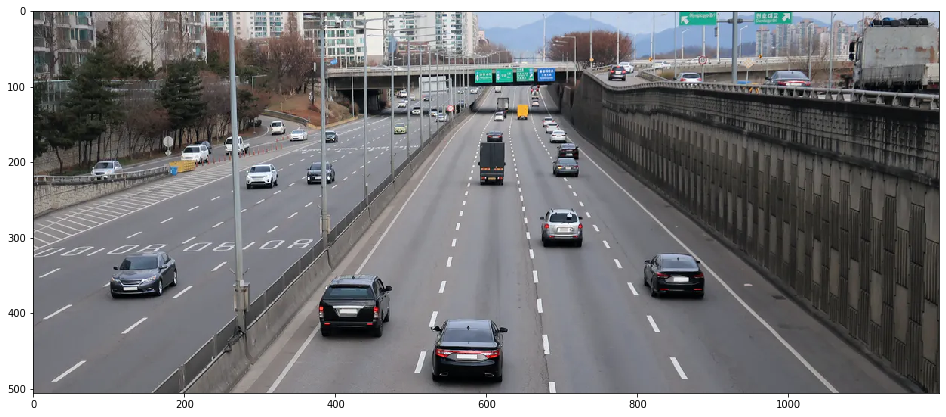

In [7]:
## Loading image  
filename = "highway.jpg"                      # filename
img = cv2.imread(filename)                    # loading image
height, width, channels = img.shape           # retrieve shape from image

## Plot image
dpi = plt.rcParams['figure.dpi']                # let's have a look at the default dpi in jupyter notebook
plt.figure(figsize = (width/dpi, height/dpi))   # to plot the image in the correct shape

img_toplot = img[:,:,::-1]      # cv2 reads the image in GBR. In order to plot, we need to convert to RGB
plt.imshow(img_toplot)
plt.show()

## Image Preprocessing

We can't use the image as input for the model as it is, but we need to convert the image to a blob in order to pass it to the model.

In [8]:
## Using blob function of opencv to preprocess image 
# (The cv2.dnn.blobFromImage function returns a blob which is our input image after
# scaling by a scale factor, and channel swapping).
# The input image that we need to pass to the Yolo algorithm must be 416x416
blob = cv2.dnn.blobFromImage(img, scalefactor = 1/255.0, size =(416, 416), swapRB=True, crop=False)   

## (Optional) - Showing what is a blob for red, green and blue channel

We can also show what is a blob for each of the 3 channels (red, green and blue)

In [14]:
## Showing blob for each channel

for b in blob:
    for n, blob_image in enumerate(b):
        cv2.imshow(str(n), blob_image)    # show blob for each of the 3 channels

cv2.waitKey(0)
cv2.destroyAllWindows()

## Object Detection (network predictions)

Now we need to pass the blob as input to the network and compute the forward pass to obtain the network prediction (output).

In [16]:
## Detecting objects in the input image (blob)

net.setInput(blob)                      # set blob as input to the network
outs = net.forward(output_layers)       # runs a forward pass to compute the network output  

## Filtering detections, building Bounding Box and Performing Non-maximum Suppression (NMS) 

1. For each detected object, if the confidence score is greater than the threshold, we compute the coordinates of the center point of the detected object, the width and the height. Then we append the box coordinates to the box list, the confidence score to the confidence list and the class to the class id list.

Up to this point we could have the same object detected more than once, that is with many overlapping bounding boxes detecting the same object. That's why we need to implement Non-maximum Suppression.

2. We implement Non-maximum Suppression:
   - first, we filter out boxes with a probability score lower than the score_threshold
   - then, we select the predictions with the maximum confidence and suppress all the other predictions having overlap with the selected predictions greater than nms_threshold (IoU threshold). 

In [17]:
class_ids = []     
confidences = []     
boxes = []   

for out in outs:         
    for detection in out:               # for each detection..
        scores = detection[5:]              # scores
        class_id = np.argmax(scores)        # class index associated to the maximum score     
        confidence = scores[class_id]       # confidence score associated to the class     
        
        if confidence > 0.5:            # if confidence score of the detected object is greater than the threshold...
        
            # Object detected                 
            center_x = int(detection[0] * width)             # x of the center point         
            center_y = int(detection[1] * height)            # y of the center point          
            w = int(detection[2] * width)                    # width of the detected object              
            h = int(detection[3] * height)                   # height of the detected object               

            # Rectangle coordinates                 
            x = int(center_x - w / 2)                         # x of the top left point          
            y = int(center_y - h / 2)                         # y of the top left point             

            boxes.append([x, y, w, h])                 
            confidences.append(float(confidence))                 
            class_ids.append(class_id)
            

## NMS - NON-MAXIMUM SUPPRESSION
# We use NMS function in opencv to perform Non-maximum Suppression  
# The function performs non maximum suppression, given boxes and corresponding confidence scores
# We give it score threshold and nms threshold as arguments:
# score_threshold: keep only boxes with a confidence score higher than the threshold
# nms threshold: threshold used in non maximum suppression (IOU)
# The function returns indices of bounding boxes survived after NMS.

indexes = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold = 0.5, nms_threshold = 0.4) 

## Image with Detected Objects and Bounding Boxes

We show the image with detected objects, corresponding bounding boxes and classes, then we also print the confidence score associated with the detected objects.

car 0.9759670495986938
car 0.9403902888298035
car 0.9838641285896301
car 0.9891537427902222
car 0.5389725565910339
car 0.6166666150093079
car 0.5255565047264099
car 0.5833790898323059
car 0.7644528150558472
car 0.5951291918754578
car 0.7061684131622314
car 0.8430553674697876
car 0.8797352910041809
car 0.9095689058303833
car 0.8125171661376953
car 0.9298293590545654
car 0.8619984984397888
truck 0.6235791444778442
car 0.9483903646469116
car 0.9327267408370972
car 0.98699551820755
car 0.97919762134552
car 0.9880232214927673


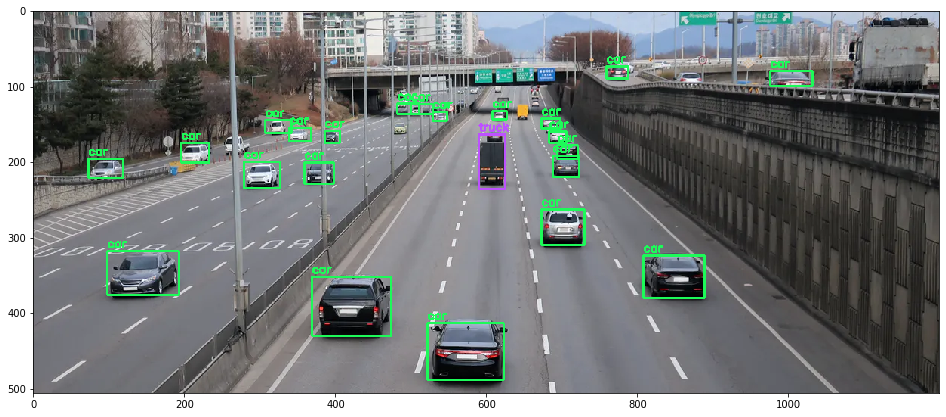

In [47]:
## Showing final image with detected objects and bounding boxes

img = cv2.imread(filename)                    # loading image
height, width, channels = img.shape           # retrieve shape from image

colors = np.random.uniform(0, 255, size=(len(classes), 3))   # generate as many random colors for bounding boxes
                                                             # as the number of classes that we have

plt.figure(figsize = (width/dpi, height/dpi))      # figure size


for i in range(len(boxes)):              # for each box...
    if i in indexes:                     # if the bounding box has survived after NMS...  
        
        x, y, w, h = boxes[i]                                   # bounding box coordinates       
        label = str(classes[class_ids[i]])                      # class label           
        color = colors[class_ids[i]]                            # colors
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)    # drawing rectangular bounding box
                                                                # (x,y) is the top left corner of the box
                                                                # (x + w, y + h) is the bottom right corner of the box
        cv2.putText(img, label, (x, y -5),cv2.FONT_HERSHEY_SIMPLEX, 1/2, color, 2)     # text of the box 
        print(label, confidences[i])                            # print labels of detected object and confidence scores
        
adj_img = img[:,:,::-1]   # convert cv2 image from GBR to RGB (in order to plot it)
plt.imshow(adj_img)       # show final image with bounding box
plt.show()

